# Analyse GPT2 model for generating utterances

This notebook is meant for analysis and visualization of the results of evaluating the GPT2 model for dialogue generation.

The first part of the notebook lists available files in the folder with evaluation results. Use an appropriate filter to load the desired file(s) to analyze.
The analysis uses two types of files as input:
- files ending with '_stats.txt' contain aggregated metrics for an evaluation run as a whole
- files ending with '_evalresults.txt' contain statistics about each sample in the test dataset, for utterance generation

The notebook has separate sections for the analysis of the stats files and evalresults files

## Setup
### Imports

In [92]:
from dataset.msc_sessions import MSC_Session
from dataset.msc_speechact import MSC_SpeechAct
from models.speechact_clf import SpeechactClassifier
import os
import json
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import math
from ast import literal_eval
from collections import Counter
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from tabulate import tabulate
from torchmetrics import BLEUScore
from torchmetrics.text.rouge import ROUGEScore

### Load stats and evalresults from outputfiles

In [93]:
# List the available files in the eval_results directory

eval_results_dir = "/Users/FrankVerhoef/Programming/PEX/output/eval_results/generation_july/"
files = sorted([item.path for item in os.scandir(eval_results_dir) if not item.is_dir() and (item.path[-4:] == '.txt')])
files

['/Users/FrankVerhoef/Programming/PEX/output/eval_results/generation_july/trained_fb_hpc_s4_nll05bart_dgpt_20230725_032648_evalresults.txt',
 '/Users/FrankVerhoef/Programming/PEX/output/eval_results/generation_july/trained_fb_hpc_s4_nll05bart_dgpt_20230725_032648_stats.txt',
 '/Users/FrankVerhoef/Programming/PEX/output/eval_results/generation_july/trained_fb_hpc_s4_nll05bart_dgpt_20230725_034459_evalresults.txt',
 '/Users/FrankVerhoef/Programming/PEX/output/eval_results/generation_july/trained_fb_hpc_s4_nll05bart_dgpt_20230725_034459_stats.txt',
 '/Users/FrankVerhoef/Programming/PEX/output/eval_results/generation_july/trained_fb_hpc_s4_nll05bart_dgpt_20230725_034646_evalresults.txt',
 '/Users/FrankVerhoef/Programming/PEX/output/eval_results/generation_july/trained_fb_hpc_s4_nll05bart_dgpt_20230725_034646_stats.txt',
 '/Users/FrankVerhoef/Programming/PEX/output/eval_results/generation_july/trained_fb_hpc_s4_nll05bart_dgpt_20230725_034652_evalresults.txt',
 '/Users/FrankVerhoef/Programmi

In [94]:
# Collect results in dicts
stats_list = []
evalresults_dict = {}
config_list = []
trial_names = list(set([
    '_'.join((f.split('/')[-1].split('_')[:-1]))
    for f in files
]))

#
# IF NECESSARY: USE ONLY SELF SELECTED FILES
#
# selection_fn = lambda s: (s.find('trained_fb_hpc_s4_nll05bart_dgpt_202307') >= 0) or (s.find('trained_hib_hpc_s4_dgpt_202307') >= 0)
# trained_fb_hpc_s4_nll05bart_dgpt_2023_07      # utterance generation or selfchat with gpt2 model trained on generated personas
# trained_hib_hpc_s4_dgpt_202307                # utterance generation or selfchat with gpt2 model trained with full dialogue history
# trial_names = sorted([f for f in trial_names if selection_fn(f)])

print(f"SELECTED TRIALS ({len(trial_names)}")
print('\n'.join(trial_names))

for trial_name in trial_names:

    # Load the '_stats' file. This contains two dicts:
    # first dict contains the aggregated statistics
    # second dict contains the configuration setting for the run
    with open(f"{eval_results_dir}{trial_name}_stats.txt") as f:
        data = f.read().replace('\n', '')
        stats = json.loads(data.split('}{')[0] + '}')
        stats["trial_name"] = trial_name
        stats["date"] = '_'.join(trial_name.split('_')[-2:])
        config = json.loads('{' + data.split('}{')[1])
        config["trial_name"] = trial_name
        stats_list.append(stats)
        config_list.append(config)

    # Load the '_evalresults' file. This contains two dicts:
    # first dict contains the testresults per sample for utterance generation
    # second dict contains the configuration setting for the run
    if os.path.isfile(f"{eval_results_dir}{trial_name}_evalresults.txt"):
        with open(f"{eval_results_dir}{trial_name}_evalresults.txt") as f:
            data = f.read().replace('\n', '')
            evalresults = json.loads(data.split('}{')[0] + '}')
            evalresults = {literal_eval(k): v for k, v in evalresults.items()}
            for k in evalresults.keys():
                evalresults[k]['trial_name'] = trial_name
            evalresults_dict[trial_name] = evalresults

# stats_dict[trial_names[0]]
print(len(stats_list), len(evalresults_dict), len(config_list))

SELECTED TRIALS (24
trained_fb_hpc_s4_nll05bart_dgpt_20230725_034459
trained_hib_hpc_s4_dgpt_20230726_112518
trained_fb_hpc_s4_nll05bart_dgpt_20230725_032648
trained_fb_hpc_s4_nll05bart_dgpt_20230726_115048
trained_hib_hpc_s4_dgpt_20230724_223322
trained_fb_hpc_s4_nll05bart_dgpt_20230726_124444
trained_fb_hpc_s4_nll05bart_dgpt_20230726_121210
trained_hib_hpc_s4_dgpt_20230726_114617
trained_hib_hpc_s4_dgpt_20230726_181734
trained_fb_hpc_s4_nll05bart_dgpt_20230727_115032
trained_hib_hpc_s4_dgpt_20230724_223155
trained_fb_hpc_s4_nll05bart_dgpt_20230725_034652
trained_hib_hpc_s4_dgpt_20230726_112600
trained_hib_hpc_s4_dgpt_20230727_115241
trained_fb_hpc_s4_nll05bart_dgpt_20230725_034646
trained_fb_hpc_s4_nll05bart_dgpt_20230727_114907
trained_hib_hpc_s4_dgpt_20230727_115202
trained_hib_hpc_s4_dgpt_20230726_121828
trained_hib_hpc_s4_dgpt_20230724_222833
trained_fb_hpc_s4_nll05bart_dgpt_20230726_123114
trained_hib_hpc_s4_dgpt_20230724_220749
trained_hib_hpc_s4_dgpt_20230724_220711
trained_fb

In [95]:
# Convert list with stats and configs to dataframe

all_stats_df = pd.DataFrame.from_dict(stats_list)
all_stats_df = all_stats_df.set_index("trial_name")
all_config_df = pd.DataFrame(config_list)
all_config_df = all_config_df.set_index("trial_name")
if 'selected_turns' in all_config_df.columns:
    all_config_df['selected_turns'] = all_config_df['selected_turns'].astype('str') 

In [96]:
# Combine stats with config

all_stats_df = all_stats_df.join(all_config_df, validate="1:1")
all_stats_df.columns

Index(['test_loss', 'test_acc', 'test_perplexity', 'eval_truncation',
       'eval_sacreblue_4', 'eval_bleu_2', 'eval_bleu_4', 'eval_bert_f1',
       'eval_rougeL_fmeasure', 'eval_rougeL_precision', 'eval_rougeL_recall',
       'eval_meteor', 'eval_google_bleu', 'eval_speechacts',
       'eval_speechpatterns', 'date', 'configfile', 'seed', 'checkpoint_dir',
       'output_dir', 'log_interval', 'loglevel', 'logdir', 'load', 'save',
       'device', 'use_wandb', 'action', 'model', 'task', 'experiment_name',
       'epochs', 'learning_rate', 'valid_interval', 'patience', 'batch_size',
       'skip_eval', 'metrics', 'print_max', 'temperature', 'top_p', 'top_k',
       'do_sample', 'num_beams', 'num_turns', 'lm', 'decoder_max', 'datadir',
       'basedir', 'train_samples', 'valid_samples', 'test_samples',
       'speaker_prefixes', 'add_tokens', 'include_persona', 'include_history',
       'input_order', 'sessionbreak_token', 'session', 'augmented',
       'selected_turns', 'persona_selecto

In [97]:
all_stats_df[(all_stats_df['date'] >='20230724')].groupby(['load', 'action'])['session'].count()

load                              action
trained_fb_hpc_s4_nll05bart_dgpt  eval      12
trained_hib_hpc_s4_dgpt           eval      12
Name: session, dtype: int64

In [98]:
# Get measurements from dataset for baseline distribution
# Load msc_measurements info if prepared file exists, otherwize calculate the measurements (which takes time ...)

basedir = "/Users/FrankVerhoef/Programming/PEX/data/msc/msc_dialogue/"
measurementsfile = basedir + 'session_measurements_gold_persona_no_hist.json'

# Need to decide which dataset/subset to use as baseline. Basically two 'logical' options:
# 1. Use session 4/test as baseline for trials with session 4, and session 5/test with trials session 5 
#    Reasoning: if evaluating you compare model generated predictions with targets from test dataset
# 2. Use session 4/train as baseline for all trials, because that is what the models were trained on.

if os.path.exists(measurementsfile):
    with open(measurementsfile, 'r') as f:
        all_msc_measurements = json.loads(f.read())
    msc_measurements = {
        4: {
            'train': all_msc_measurements['4']['gold_persona_no_hist']['train'],
            'test':  all_msc_measurements['4']['gold_persona_no_hist']['test']
        },
        5: {
            'test':  all_msc_measurements['5']['gold_persona_no_hist']['test']
        }
    }
    print("Loaded precalculated msc_measurements")
else:
    speechact_classifier = SpeechactClassifier(
        checkpoint_dir="/Users/FrankVerhoef/Programming/PEX/checkpoints/", 
        modelname="trained_speechact_bert"
    )
    MSC_Session.set(speaker_prefixes=['<other>', '<self>'], sessionbreak_token='<session>', speechact_classifier=speechact_classifier)
    msc_measurements = {}
    for session, subset in [(4, 'train'), (4, 'test'), (5, 'test')]:
        if session not in msc_measurements.keys():
            msc_measurements[session] = {}
        for subset in ['train', 'test']:
            msc_session = MSC_Session(
                basedir="/Users/FrankVerhoef/Programming/PEX/data/msc/msc_dialogue/", 
                session=session, 
                subset=subset, 
                include_history=False,
                include_persona=True,
                persona_selector=None, # means 'gold' persona
                augmented=False
            )
            # getting meaasurements for session 5 takes 18 minutes on MacBookPro
            # getting meaasurements for session 4 takes 13 minutes on MacBookPro
            msc_measurements[session][subset] = msc_session.measurements()


Loaded precalculated msc_measurements


### Helper functions

In [99]:
def mse(values, baseline):
    diff = values - baseline
    return np.mean(diff * diff)

def mad(values, baseline):
    diff = np.absolute(values - baseline)
    return np.mean(diff)

def tvd(values, baseline):
    diff = np.absolute(values - baseline)
    return np.sum(diff) / 2

def normalize(counter):
    total = sum(counter.values())
    normalized = {k: v / total for k, v in counter.items()}
    return normalized

def count_words(utterance):
    u = utterance.replace('<self>', '').replace('<other>', '').replace('\n', '')
    return len(u.split(' '))

def format_gen_config(settings):
    # settings contains: do_sample, num_beams, temp, top_p, top_k
    if settings[0] == False:
        return "Greedy"
    else:
        if settings[1] == 1 and settings[2] == 1.0 and settings[3] == 1.0 and settings[4] == 0:
            return "Unbiased sampling"
        elif settings[1] == 5 and settings[2] == 1.0 and settings[3] == 0.9 and settings[4] == 10:
            return "Narrow beam"
        elif settings[1] == 5 and settings[2] == 1.5 and settings[3] == 0.9 and settings[4] == 10:
            return "Flat-Narrow beam"
        elif settings[1] == 5 and settings[2] == 1.5 and settings[3] == 0.9 and settings[4] == 50:
            return "Flat-Broad beam"
        else:
            return f"b={int(settings[1])}, t={settings[2]:.1f}, top_p={settings[3]:.1f}, top_k={int(settings[4])}"

def format_modelname(s):
    name = {
        'trained_hib_hpc_s4_dgpt': 'Base', 
        'trained_fb_hpc_s4_nll05bart_dgpt': 'PERSUM'
    }[s]
    return name

def multicolumn_filter(df, cols, values):
    for c, v in zip(cols, values):
        condition = df[c] == v
        df = df[condition]
    return df

model_config = ['load', 'include_history', 'include_persona', 'persona_selector']
gen_config_params = ['do_sample', 'num_beams', 'temperature', 'top_p', 'top_k']
gen_config_cat = CategoricalDtype(['Greedy', 'Unbiased sampling','Narrow beam', 'Flat-Narrow beam', 'Flat-Broad beam'], ordered=True)

sorted_by_value = lambda d: [k for k, v in sorted(d.items(), key=lambda x: x[1], reverse=True)]
sorted_by_keylen = lambda d: sorted(d.keys(), key=lambda x: (len(x), x))

### Add info columns to all_stats_df

In [100]:
all_stats_df['gen_config'] = all_stats_df[gen_config_params].apply(format_gen_config, axis=1).astype(gen_config_cat)

## Utterance generation

### Speechacts

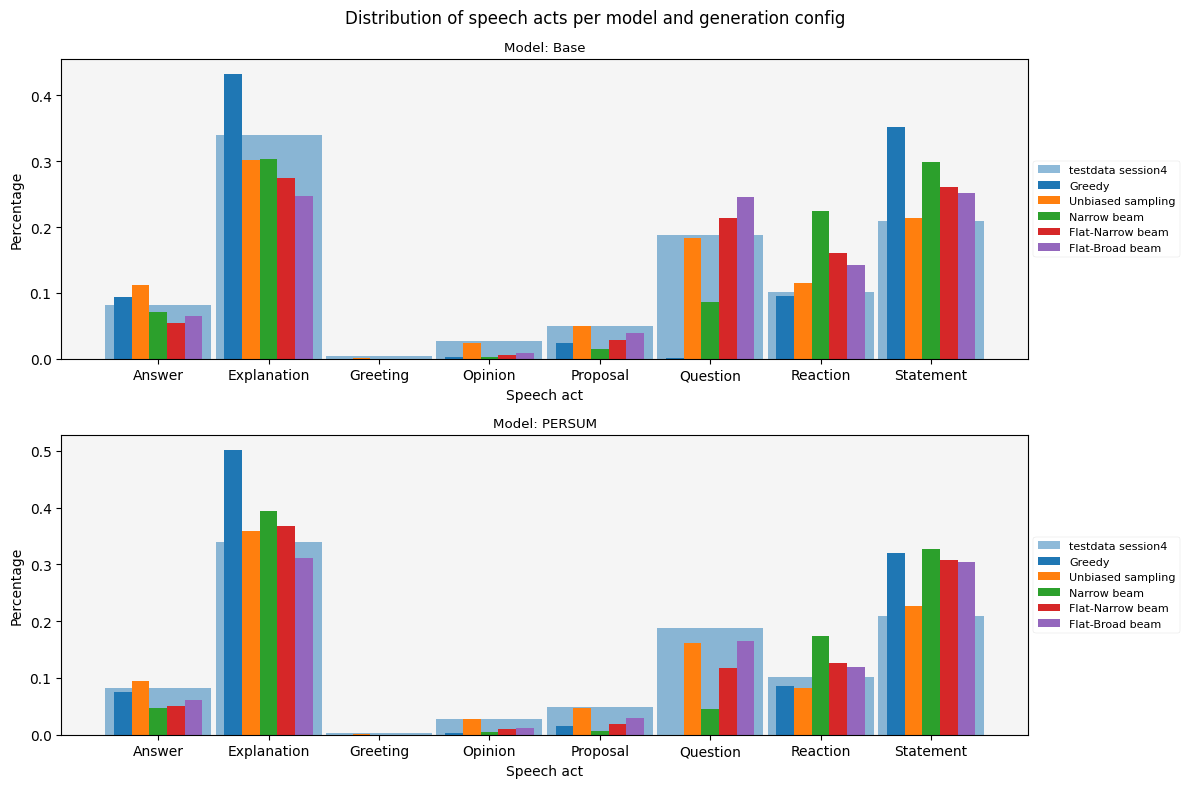

In [101]:
# Show distribution of speechacts per trial

# Choose session to visualize, baseline and other filter parameters
session = 4
baseline_subset = 'test'
baseline_session = 4
speechact_baseline = msc_measurements[baseline_session][baseline_subset]['speechacts']

model_list = ['trained_hib_hpc_s4_dgpt', 'trained_fb_hpc_s4_nll05bart_dgpt']

all_acts = list(MSC_SpeechAct.classes.keys())
x_labels = list(MSC_SpeechAct.classes.values())
x = np.arange(len(x_labels))
gap_width = 0.2

selection = (all_stats_df['action'] == 'eval') \
    & (all_stats_df['session'] == session) \
    & (all_stats_df['date'] >= '202307') \
    & ((all_stats_df['do_sample'] == False) | (all_stats_df['num_beams'] != 1) | (all_stats_df['top_k'] == 0))

fig, axs = plt.subplots(ncols=1, nrows=2, figsize=(12,8))

for model_name, ax in zip(model_list, axs):

    subselection = (all_stats_df['load'] == model_name)
    df = all_stats_df[selection & subselection].sort_values(by=gen_config_params)
    speechact_dicts = [dict(item) for item in df['eval_speechacts']]

    bar_width = (1-gap_width) / len(df)

    with plt.style.context('seaborn-v0_8-paper'):

        baseline_y = np.array([speechact_baseline.get(a, 0) for a in all_acts]) / sum(speechact_baseline.values())
        ax.bar(x=x, height=baseline_y, width=0.96, alpha=0.5, color='tab:blue', label=f"{baseline_subset}data session{baseline_session}")

        for i, index in enumerate(df.index):
            row = df.loc[index]
            speechact_dict = dict(row['eval_speechacts'])
            y = np.array([speechact_dict.get(a, 0) for a in all_acts])
            row_config = df.loc[index][gen_config_params].values
            label = format_gen_config(row_config)
            # print(trial_name, label)
            # print(y)
            offset = -(1-gap_width)/2 + bar_width / 2 + bar_width * i
            ax.bar(x=x+offset, height=y, width=bar_width, label=label)

        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        ax.set_xticks(x)
        ax.set_xticklabels(x_labels)

        ax.set_facecolor('whitesmoke')
        ax.set_title(f"Model: {format_modelname(model_name)}")
        ax.set_ylabel("Percentage")
        ax.set_xlabel("Speech act")

fig.suptitle(f"Distribution of speech acts per model and generation config")
fig.tight_layout()

Average tvd between models: 0.11


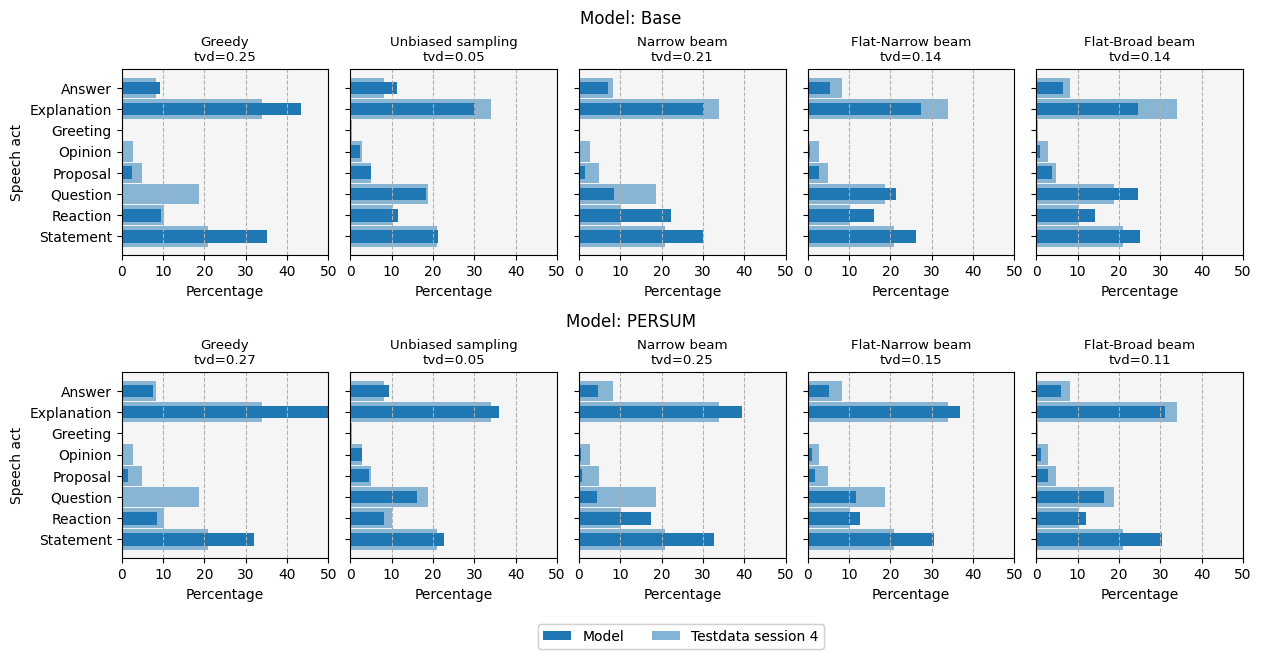

In [102]:
### ***THESIS*** Figure 5.4 and Figure F.1

# Show distribution of speechacts per trial

# Choose session to visualize, baseline and other filter parameters
session = 4
baseline_subset = 'test'
baseline_session = 4
speechact_baseline = msc_measurements[baseline_session][baseline_subset]['speechacts']
baseline_label = f"{baseline_subset[0].upper()}{baseline_subset[1:]}data session {baseline_session}"

model_list = ['trained_hib_hpc_s4_dgpt', 'trained_fb_hpc_s4_nll05bart_dgpt']

all_acts = sorted(MSC_SpeechAct.classes.keys())
y_labels = sorted(MSC_SpeechAct.classes.values())
y = np.arange(len(y_labels))

selection = (all_stats_df['action'] == 'eval') \
    & (all_stats_df['session'] == session) \
    & (all_stats_df['date'] >= '202307') \
    & ((all_stats_df['do_sample'] == False) | (all_stats_df['num_beams'] != 1) | (all_stats_df['top_k'] == 0))
gen_configs = all_stats_df[selection].groupby(by=gen_config_params).size().index
# print(gen_configs)
# print(all_stats_df[selection]['date'])

subfigs = plt.figure(layout='constrained', figsize=(2.5*len(gen_configs), 3*len(model_list))).subfigures(2, 1)
all_xs = []
for model_name, subfig in zip(model_list, subfigs):

    subselection = (all_stats_df['load'] == model_name)
    df = all_stats_df[selection & subselection].sort_values(by=gen_config_params)
    # print(df['eval_speechacts'])

    gen_configs = df[gen_config_params].values
    speechact_dicts = [Counter(item) for item in df['eval_speechacts']]
    # print(speechact_dicts)
    # print(gen_configs)

    axs = subfig.subplots(ncols=len(gen_configs), nrows=1, sharey=True, sharex=True)
    model_xs = []
    with plt.style.context('seaborn-v0_8-paper'):
        for d, row_config, ax in zip(speechact_dicts, gen_configs, axs):

            baseline_x = np.array([speechact_baseline.get(a, 0) for a in all_acts]) / sum(speechact_baseline.values())
            ax.barh(y, width=baseline_x, height=0.96, color='tab:blue', alpha=0.5, label=baseline_label)

            x = np.array([d.get(pattern, 0) for pattern in all_acts])
            title = format_gen_config(row_config)
            # print(y_labels)
            # print(x)
            ax.barh(y, width=x, height=0.6, color='tab:blue', label="Model")
            model_xs.append(x)

            
            ax.set_facecolor('whitesmoke')
            ax.set_title(f"{title}\ntvd={tvd(x, baseline_x):.2f}")
            ax.set_yticks(y)
            ax.set_yticklabels(y_labels)
            ax.invert_yaxis()
            ax.set_xlim(0, 0.5)
            ax.set_xticks(np.arange(6) * 0.1)
            ax.set_xticklabels(np.arange(0, 60, 10))
            ax.set_xlabel("Percentage")
            ax.grid(which='major', axis='x', linestyle='--')

    all_xs.append(model_xs)

    axs[0].set_ylabel("Speech act")
    subfig.suptitle(f"Model: {format_modelname(model_name)}")
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    subfigs[-1].legend(by_label.values(), by_label.keys(), loc='lower center', ncols=2, bbox_to_anchor=(0.54, -0.17), reverse=True)

avg_tvd_diff = np.array([
    np.array(tvd(np.array(x0), np.array(x1)))
    for x0, x1 in zip(all_xs[0], all_xs[1])
]).mean()
print(f"Average tvd between models: {avg_tvd_diff:.2f}")

fig.tight_layout()
plt.savefig(f'../docs/gen_speechacts{session}.pdf', dpi=300, format='pdf', bbox_inches='tight')

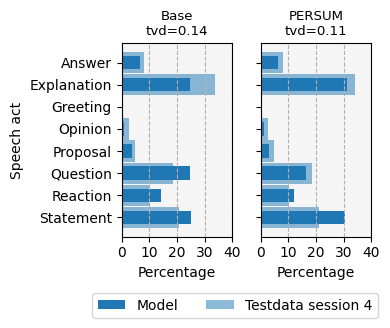

In [103]:
### ***ARTICLE*** Figure 

# Show distribution of speechacts per trial, for ONE chose generation config

# Choose session to visualize, baseline and other filter parameters
session = 4
baseline_subset = 'test'
baseline_session = 4
speechact_baseline = msc_measurements[baseline_session][baseline_subset]['speechacts']
baseline_label = f"{baseline_subset[0].upper()}{baseline_subset[1:]}data session {baseline_session}"

model_list = ['trained_hib_hpc_s4_dgpt', 'trained_fb_hpc_s4_nll05bart_dgpt']

all_acts = sorted(MSC_SpeechAct.classes.keys())
y_labels = sorted(MSC_SpeechAct.classes.values())
y = np.arange(len(y_labels))

selection = (all_stats_df['action'] == 'eval') \
    & (all_stats_df['session'] == session) \
    & (all_stats_df['date'] >= '202307') \
    & ((all_stats_df['do_sample'] == True) & (all_stats_df['num_beams'] == 5) & (all_stats_df['temperature'] == 1.5) & (all_stats_df['top_p'] == 0.9) & (all_stats_df['top_k'] == 50)) # Flat-broad beam
# print(all_stats_df[selection]['date'])

fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(4,3), sharey=True)

with plt.style.context('seaborn-v0_8-paper'):
    for model_name, ax in zip(model_list, axs):

        subselection = (all_stats_df['load'] == model_name)
        df = all_stats_df[selection & subselection].sort_values(by=gen_config_params)
        speechact_dicts = [Counter(item) for item in df['eval_speechacts']]
        d = speechact_dicts[0]
        # print(d)

        baseline_x = np.array([speechact_baseline.get(a, 0) for a in all_acts]) / sum(speechact_baseline.values())
        ax.barh(y, width=baseline_x, height=0.96, color='tab:blue', alpha=0.5, label=baseline_label)

        x = np.array([d.get(pattern, 0) for pattern in all_acts])
        title = format_modelname(model_name)
        # print(y_labels)
        # print(x)
        ax.barh(y, width=x, height=0.6, color='tab:blue', label="Model")
        ax.set_facecolor('whitesmoke')
        ax.set_title(f"{title}\ntvd={tvd(x, baseline_x):.2f}")
        ax.set_xlim(0, 0.4)
        ax.set_xticks(np.arange(5) * 0.1)
        ax.set_xticklabels(np.arange(0, 50, 10))
        ax.set_xlabel("Percentage")
        ax.grid(which='major', axis='x', linestyle='--')

axs[0].set_ylabel("Speech act")
axs[0].invert_yaxis()
axs[0].set_yticks(y)
axs[0].set_yticklabels(y_labels)

# fig.title(f"Model: {format_modelname(model_name)}")
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
fig.legend(by_label.values(), by_label.keys(), loc='lower center', ncols=2, bbox_to_anchor=(0.6, -0.1), reverse=True)

fig.tight_layout()
plt.savefig(f'../docs/gen_speechacts{session}_fbb.pdf', dpi=300, format='pdf', bbox_inches='tight')

### Speechpatterns

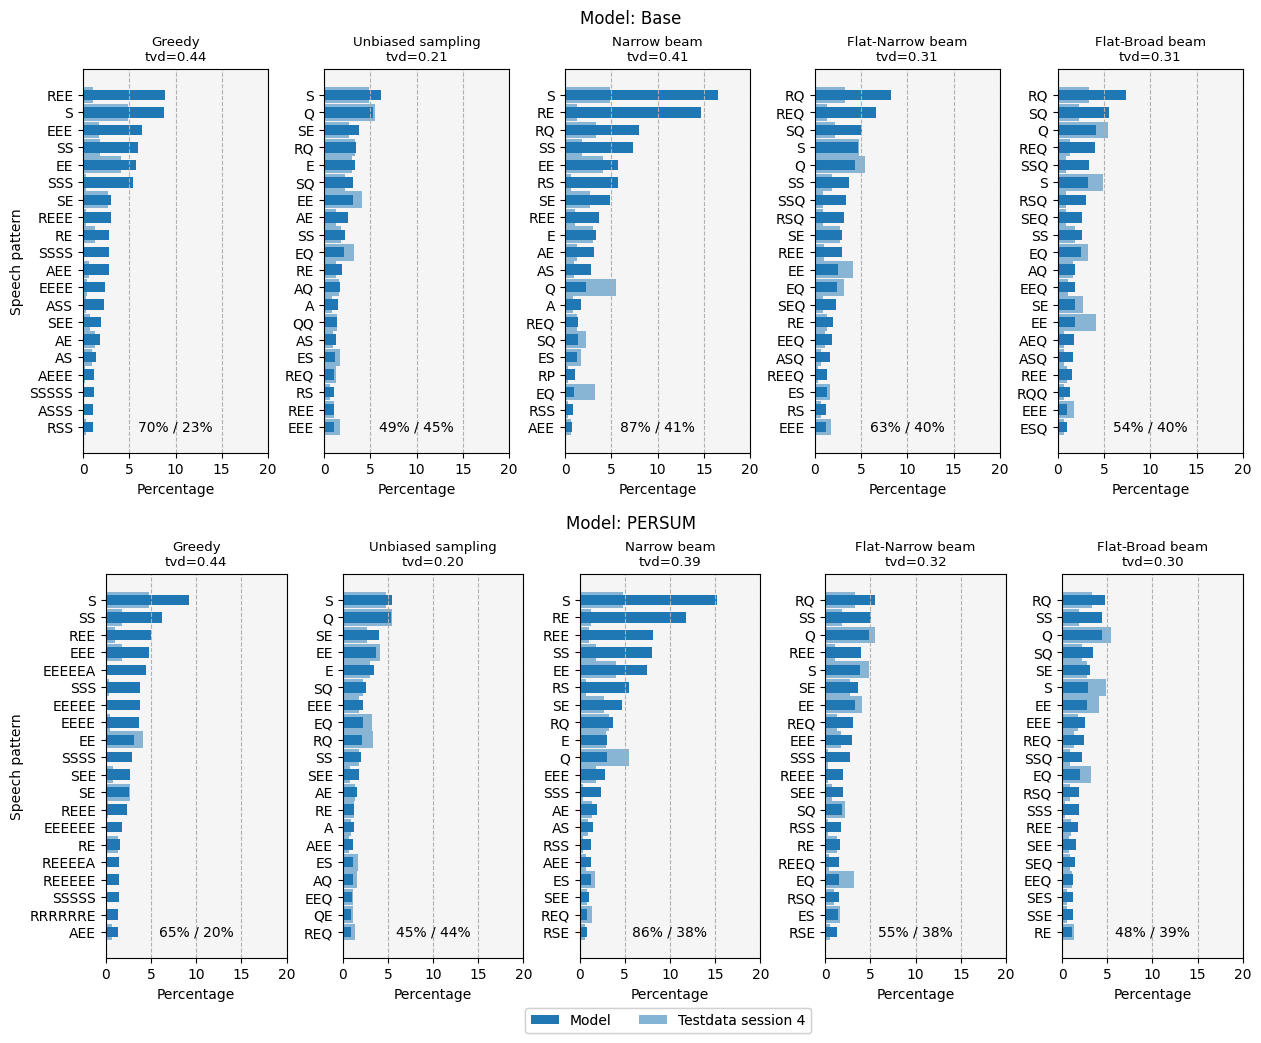

In [104]:
# Show distribution of speechpatterns per trial

# Choose session to visualize, baseline and other filter parameters
session = 4
baseline_subset = 'test'
baseline_session = 4
speechpattern_baseline = msc_measurements[baseline_session][baseline_subset]['speechpatterns']
baseline_label = f"{baseline_subset[0].upper()}{baseline_subset[1:]}data session {baseline_session}"

model_list = ['trained_hib_hpc_s4_dgpt', 'trained_fb_hpc_s4_nll05bart_dgpt']

max_patterns = 20
y = np.arange(max_patterns)
x_max = 0.2

selection = (all_stats_df['action'] == 'eval') \
    & (all_stats_df['session'] == session) \
    & (all_stats_df['date'] >= '202307') \
    & ((all_stats_df['do_sample'] == False) | (all_stats_df['num_beams'] != 1) | (all_stats_df['top_k'] == 0))
gen_configs = all_stats_df[selection].groupby(by=gen_config_params).size().index
# print(gen_configs.index)
# print(all_stats_df[selection]['date'])

subfigs = plt.figure(layout='constrained', figsize=(2.5*len(gen_configs), 5*len(model_list))).subfigures(2, 1)

for model_name, subfig in zip(model_list, subfigs):

    axs = subfig.subplots(ncols=len(gen_configs), nrows=1)

    subselection = (all_stats_df['load'] == model_name)
    df = all_stats_df[selection & subselection].sort_values(by=gen_config_params)
    # print(df['eval_speechpatterns'])

    gen_configs = df[gen_config_params].values
    speechpattern_dicts = [Counter(item) for item in df['eval_speechpatterns']]

    # print(speechpattern_dicts)
    # print(gen_configs)

    with plt.style.context('seaborn-v0_8-paper'):
        for d, row_config, ax in zip(speechpattern_dicts, gen_configs, axs):

            y_labels = sorted_by_value(d)
            x = np.array([d.get(pattern, 0) for pattern in y_labels])
            title = format_gen_config(row_config)
            # print(y_labels[:max_patterns])
            # print(x[:max_patterns])

            baseline_x = np.array([speechpattern_baseline.get(pattern, 0) for pattern in y_labels]) / sum(speechpattern_baseline.values())
            ax.barh(y, width=baseline_x[:max_patterns], height=0.96, color='tab:blue', alpha=0.5, label=baseline_label)
            
            ax.barh(y, width=x[:max_patterns], height=0.6, label="Model")
            ax.text(x_max / 2, max_patterns - 1, f"{sum(x[:max_patterns]):.0%} / {sum(baseline_x[:max_patterns]):.0%}", ha='center', va='center')

            ax.set_facecolor('whitesmoke')
            ax.set_title(f"{title}\ntvd={tvd(x, baseline_x):.2f}")
            ax.set_yticks(y)
            ax.set_yticklabels(y_labels[:max_patterns])
            ax.invert_yaxis()
            ax.set_xlim(0, x_max)
            ax.set_xticks(np.linspace(0, x_max, 5))
            ax.set_xticklabels(np.arange(0, x_max * 100 + 1, x_max * 100 / 4, dtype=int))
            ax.set_xlabel("Percentage")
            ax.grid(which='major', axis='x', linestyle='--')

    axs[0].set_ylabel("Speech pattern")
            
    subfig.suptitle(f"Model: {format_modelname(model_name)}")
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    subfigs[-1].legend(by_label.values(), by_label.keys(), loc='lower center', ncols=2, bbox_to_anchor=(0.53, -0.07), reverse=True)
    
fig.tight_layout()

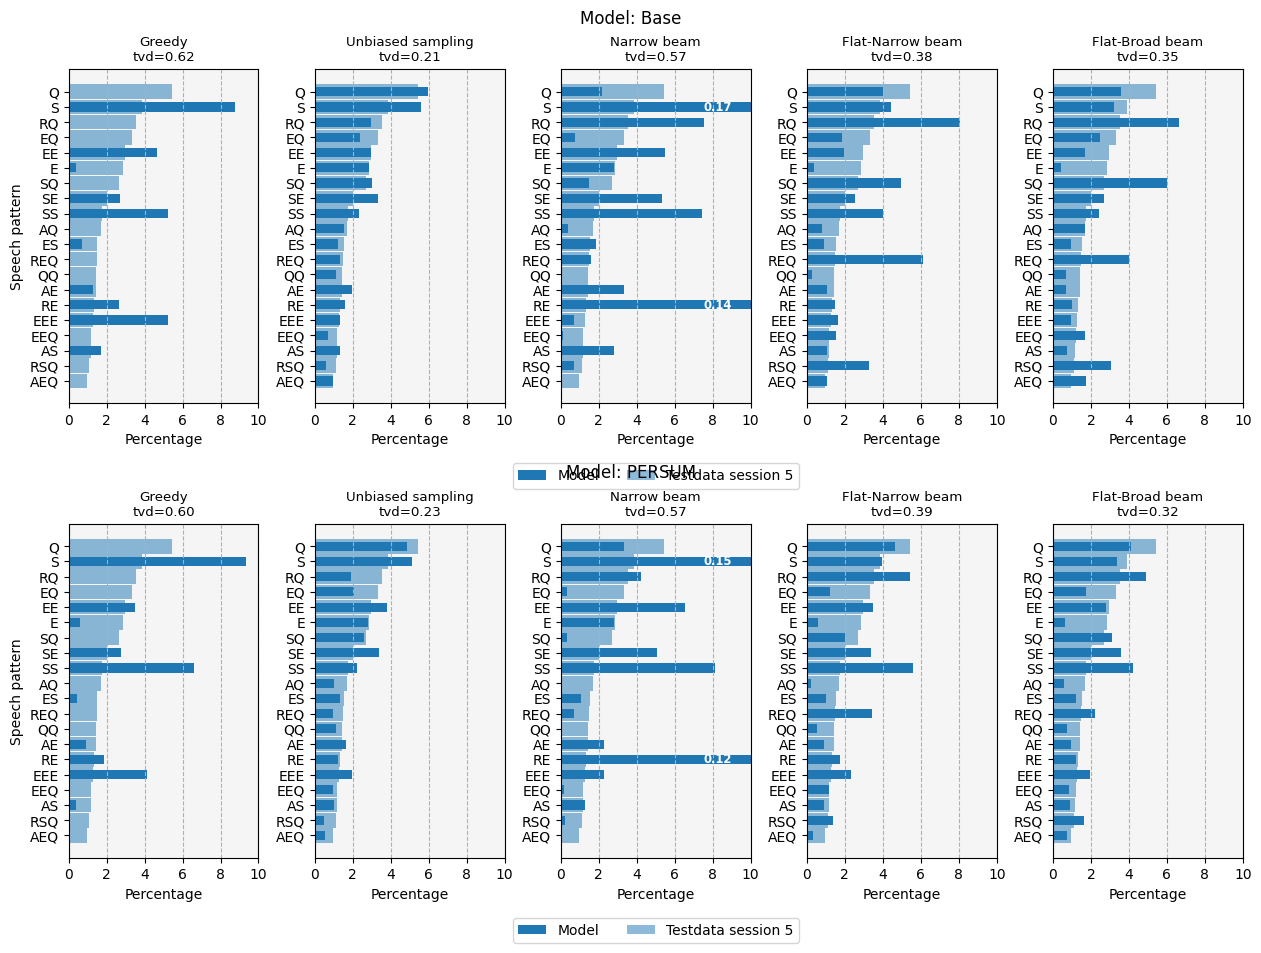

In [105]:
### ***THESIS*** Figure 5.5 and Figure F.2

# Show distribution of speechpatterns per trial

# Choose session to visualize, baseline and other filter parameters
session = 5
baseline_subset = 'test'
baseline_session = 5
speechpattern_baseline = msc_measurements[baseline_session][baseline_subset]['speechpatterns']
baseline_label = f"{baseline_subset[0].upper()}{baseline_subset[1:]}data session {baseline_session}"

model_list = ['trained_hib_hpc_s4_dgpt', 'trained_fb_hpc_s4_nll05bart_dgpt']

max_patterns = 20
y = np.arange(max_patterns)
y_labels = sorted_by_value(speechpattern_baseline)
baseline_x = np.array([speechpattern_baseline[pattern] for pattern in y_labels]) / sum(speechpattern_baseline.values())
x_max = 0.1

selection = (all_stats_df['action'] == 'eval') \
    & (all_stats_df['session'] == session) \
    & (all_stats_df['date'] >= '202307') \
    & ((all_stats_df['do_sample'] == False) | (all_stats_df['num_beams'] != 1) | (all_stats_df['top_k'] == 0))
gen_configs = all_stats_df[selection].groupby(by=gen_config_params).size().index
# print(gen_configs.index)
# print(all_stats_df[selection]['date'])

subfigs = plt.figure(layout='constrained', figsize=(2.5*len(gen_configs), 4.5*len(model_list))).subfigures(2, 1)

for model_name, subfig in zip(model_list, subfigs):

    subselection = (all_stats_df['load'] == model_name)
    df = all_stats_df[selection & subselection].sort_values(by=gen_config_params)
    # print(df['eval_speechpatterns'])

    gen_configs = df[gen_config_params].values
    speechpattern_dicts = [Counter(item) for item in df['eval_speechpatterns']]
    # print(speechpattern_dicts)
    # print(gen_configs)
    
    axs = subfig.subplots(ncols=len(gen_configs), nrows=1)
    with plt.style.context('seaborn-v0_8-paper'):
        for d, row_config, ax in zip(speechpattern_dicts, gen_configs, axs):

            x = np.array([d.get(pattern, 0) for pattern in y_labels])
            title = format_gen_config(row_config)
            # print(y_labels[:max_patterns])
            # print(x[:max_patterns])

            ax.barh(y, width=baseline_x[:max_patterns], height=0.96, color='tab:blue', alpha=0.5, label=baseline_label)
            
            ax.barh(y, width=x[:max_patterns], height=0.6, label="Model")
            # ax.text(x_max / 2, max_patterns - 1, f"{sum(x[:max_patterns]):.0%} / {sum(baseline_x[:max_patterns]):.0%}", ha='center', va='center')

            for item_y, item_x in zip(y, x[:max_patterns]):
                if item_x > x_max:
                    ax.text(0.9 * x_max, item_y, f"{item_x:.2f}", va='center', ha='right', color='w', fontsize='small', fontweight='bold')

            ax.set_facecolor('whitesmoke')
            ax.set_title(f"{title}\ntvd={tvd(x, baseline_x):.2f}")
            ax.set_yticks(y)
            ax.set_yticklabels(y_labels[:max_patterns])
            ax.invert_yaxis()
            ax.set_xlim(0, x_max)
            ax.set_xticks(np.linspace(0, x_max, 6))
            ax.set_xticklabels(np.arange(0, x_max * 100 + 1, x_max * 100 / 5, dtype=int))
            ax.set_xlabel("Percentage")
            ax.grid(which='major', axis='x', linestyle='--')

    axs[0].set_ylabel("Speech pattern")
            
    subfig.suptitle(f"Model: {format_modelname(model_name)}")
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    subfig.legend(by_label.values(), by_label.keys(), loc='lower center', bbox_to_anchor=(0.52, -0.1), ncols=2, reverse=True)
    
fig.tight_layout()
plt.savefig(f'../docs/gen_speechpatterns_{session}.pdf', dpi=300, format='pdf', bbox_inches='tight')

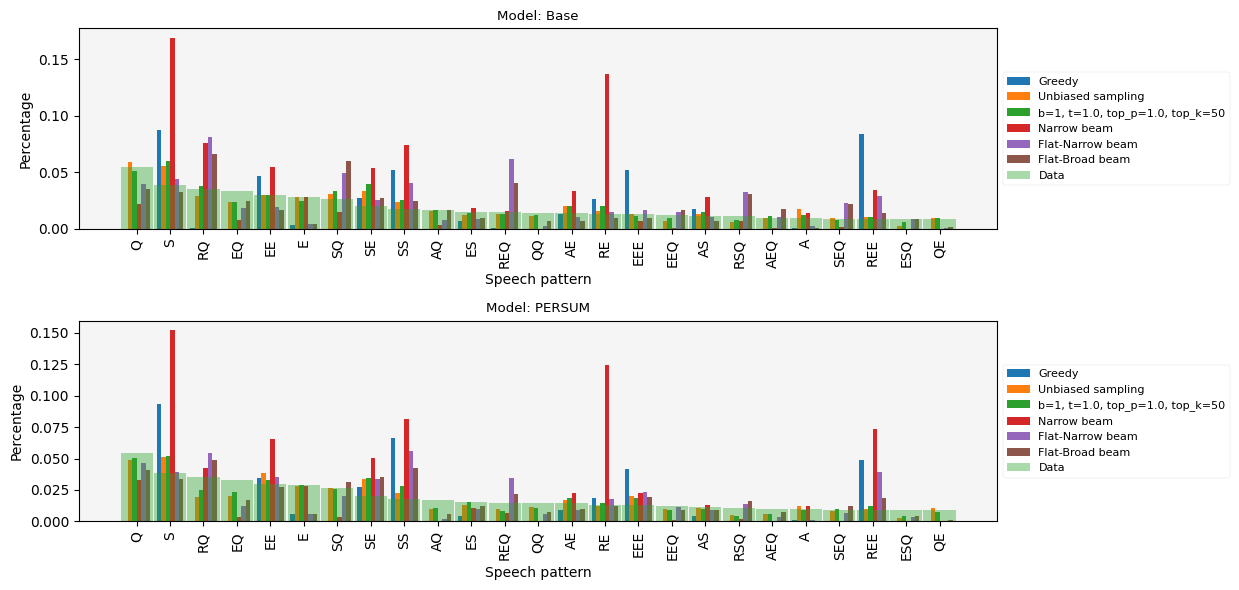

In [106]:
# Show distribution of speechpatterns per trial

session = 5
model_list = ['trained_hib_hpc_s4_dgpt', 'trained_fb_hpc_s4_nll05bart_dgpt']

baseline_subset = 'test'
baseline_session = 5
speechpattern_baseline = msc_measurements[baseline_session][baseline_subset]['speechpatterns']
baseline_label = f"{baseline_subset[0].upper()}{baseline_subset[1:]}data session {baseline_session}"

max_patterns = 25
patterns_by_value = [k for k, v in sorted(speechpattern_baseline.items(), key=lambda x: x[1], reverse=True)]
patterns_by_keylen = sorted(speechpattern_baseline.keys(), key=lambda x: (len(x), x))
x_labels = patterns_by_value[:max_patterns]
x = np.arange(len(x_labels))

fig, axs = plt.subplots(ncols=1, nrows=len(model_list), figsize=(len(x_labels)*0.5, 6))

for model_name, ax in zip(model_list, axs):

    selection = (all_stats_df['action'] == 'eval') & (all_stats_df['load'] == model_name) & (all_stats_df['session'] == session)
    df = all_stats_df[selection].sort_values(by=gen_config_params)

    gap_width = 0.2
    bar_width = (1-gap_width) / len(df)

    speechpattern_dicts = [Counter(item) for item in df['eval_speechpatterns']]
    generated_patterns = set().union(*[d.keys() for d in speechpattern_dicts])
    avg_pattern_distribution = {p: sum([d[p] for d in speechpattern_dicts])/len(speechpattern_dicts) for p in generated_patterns}

    with plt.style.context('seaborn-v0_8-paper'):
        for i, index in enumerate(df.index):
            row = df.loc[index]
            speechpattern_dict = dict(row['eval_speechpatterns'])
            y = np.array([speechpattern_dict.get(pattern, 0) for pattern in x_labels])
            row_config = df.loc[index][gen_config_params].values
            label = format_gen_config(row_config)
            # print(label)
            # print(y)
            offset = -(1-gap_width)/2 + bar_width / 2 + bar_width * i
            ax.bar(x=x+offset, height=y, width=bar_width, label=label)

        baseline_y = np.array([speechpattern_baseline.get(pattern, 0) for pattern in x_labels]) / sum(speechpattern_baseline.values())
        ax.bar(x=x, height=baseline_y, width=0.96, color='tab:green', alpha=0.4, label="Data")

        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        ax.set_xticks(x)
        ax.set_xticklabels(x_labels, rotation=90)

        ax.set_facecolor('whitesmoke')
        ax.set_title(f"Model: {format_modelname(model_name)}")
        ax.set_ylabel("Percentage")
        ax.set_xlabel("Speech pattern")
    
fig.tight_layout()

### Number of words

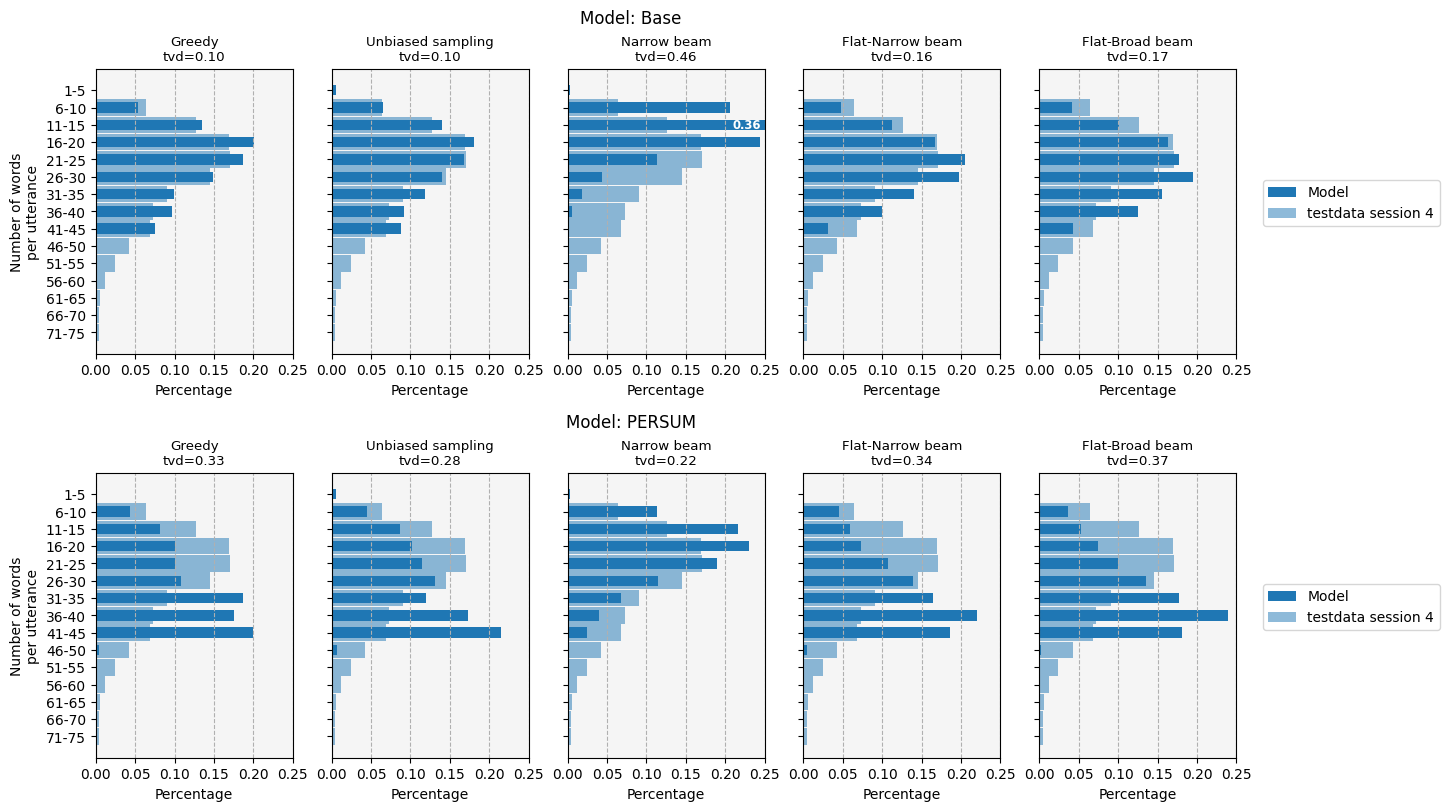

In [107]:
# Show distribution of number of words in generated utterances per trial

session = 4
baseline_subset = 'test'
baseline_session = 4
model_list = ['trained_hib_hpc_s4_dgpt', 'trained_fb_hpc_s4_nll05bart_dgpt']

nbins = 15
bin_max = 75
bin_edges = np.linspace(0, bin_max, nbins + 1)
bins = list(zip(bin_edges[:-1] + 1, bin_edges[1:]))

y_labels = [f"{int(l)}-{int(u)}" for l, u in bins]
y = np.arange(len(y_labels))
# print(y_labels)

numwords_baseline = np.histogram([item['labelwords'] for item in msc_measurements[baseline_session][baseline_subset]['allitem_measurements']], bins=bin_edges)[0]
baseline_x = numwords_baseline / sum(numwords_baseline)
max_x = 0.25
# print(baseline_x)

selection = (all_stats_df['action'] == 'eval') \
    & (all_stats_df['session'] == session) \
    & (all_stats_df['date'] >= '202307') \
    & ((all_stats_df['do_sample'] == False) | (all_stats_df['num_beams'] != 1) | (all_stats_df['top_k'] == 0))
gen_configs = all_stats_df[selection].groupby(by=gen_config_params).size().index
# print(gen_configs)
# print(all_stats_df[selection]['date'])

subfigs = plt.figure(layout='constrained', figsize=(2.5*len(gen_configs), 4*len(model_list))).subfigures(2, 1)

for model_name, subfig in zip(model_list, subfigs):

    axs = subfig.subplots(ncols=len(gen_configs), nrows=1, sharey=True, sharex=True)

    subselection = (all_stats_df['load'] == model_name)
    df = all_stats_df[selection & subselection].sort_values(by=gen_config_params)
    # print(df['eval_speechacts'])

    gen_configs = df[gen_config_params].values
    trial_selection = df.index
    # print(trial_selection)
    numwords_histograms = [
        np.histogram([
            count_words(evalresults_dict[trial_name][idx]['pred_response'])
            for idx in evalresults_dict[trial_name]
        ], bins=bin_edges)[0]
        for trial_name in trial_selection
    ]

    # print(numwords_histograms)
    # print(gen_configs)

    with plt.style.context('seaborn-v0_8-paper'):
        for h, row_config, ax in zip(numwords_histograms, gen_configs, axs):

            ax.barh(y, width=baseline_x, height=0.96, color='tab:blue', alpha=0.5, label=f"{baseline_subset}data session {baseline_session}")

            x = h / sum(h)
            title = format_gen_config(row_config)
            # print(y_labels)
            # print(x)
            ax.barh(y, width=x, height=0.6, color='tab:blue', label="Model")

            for item_y, item_x in zip(y, x):
                if item_x > max_x:
                    ax.text(0.98 * max_x, item_y, f"{item_x:.2f}", va='center', ha='right', color='w', fontsize='small', fontweight='bold')


            ax.set_facecolor('whitesmoke')
            ax.set_title(f"{title}\ntvd={tvd(x, baseline_x):.2f}")
            ax.set_yticks(y)
            ax.set_yticklabels(y_labels)
            ax.invert_yaxis()
            ax.set_xlim(0, max_x)
            ax.set_xticks(np.arange(6) * max_x / 5)
            ax.set_xlabel("Percentage")
            ax.grid(which='major', axis='x', linestyle='--')

    axs[0].set_ylabel("Number of words\nper utterance")

    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    subfig.legend(by_label.values(), by_label.keys(), loc='center left', bbox_to_anchor=(1, 0.5), reverse=True)
    subfig.suptitle(f"Model: {format_modelname(model_name)}")

    
fig.tight_layout()

### Number of speechacts

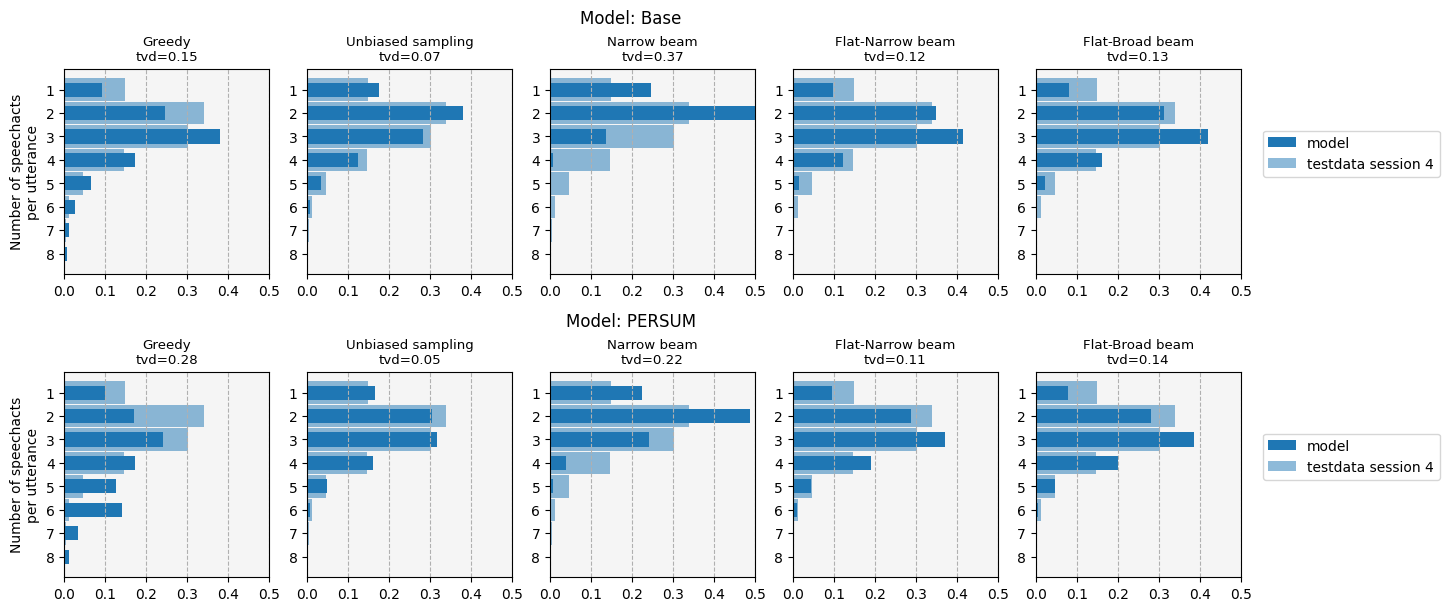

In [108]:
# Show distribution of number of speechacts in generated utterances per trial

def sum_by_lenp(proportions):
    d = {}
    for p, v in proportions.items():
        if len(p) in d.keys():
            d[len(p)] += v
        else:
            d[len(p)] = v
    return d

session = 4
baseline_subset = 'test'
baseline_session = 4
model_list = ['trained_hib_hpc_s4_dgpt', 'trained_fb_hpc_s4_nll05bart_dgpt']

range_max = 8

y_labels = np.arange(range_max, dtype=int) + 1
y = np.arange(len(y_labels))
# print(y_labels)

numacts_baseline = sum_by_lenp(msc_measurements[baseline_session][baseline_subset]['speechpatterns'])
baseline_x = np.array([numacts_baseline.get(len_p, 0) for len_p in y_labels]) / sum(numacts_baseline.values())
# print(baseline_x)

selection = (all_stats_df['action'] == 'eval') \
    & (all_stats_df['session'] == session) \
    & (all_stats_df['date'] >= '202307') \
    & ((all_stats_df['do_sample'] == False) | (all_stats_df['num_beams'] != 1) | (all_stats_df['top_k'] == 0))
gen_configs = all_stats_df[selection].groupby(by=gen_config_params).size().index
# print(gen_configs)
# print(all_stats_df[selection]['date'])

subfigs = plt.figure(layout='constrained', figsize=(2.5*len(gen_configs), 3*len(model_list))).subfigures(2, 1)

for model_name, subfig in zip(model_list, subfigs):

    axs = subfig.subplots(ncols=len(gen_configs), nrows=1)

    subselection = (all_stats_df['load'] == model_name)
    df = all_stats_df[selection & subselection].sort_values(by=gen_config_params)
    # print(df['eval_speechpatterns'])

    gen_configs = df[gen_config_params].values
    speechpattern_dicts = [sum_by_lenp(dict(item)) for item in df['eval_speechpatterns']]

    # print(speechpattern_dicts)
    # print(gen_configs)

    with plt.style.context('seaborn-v0_8-paper'):
        for d, row_config, ax in zip(speechpattern_dicts, gen_configs, axs):

            ax.barh(y, width=baseline_x, height=0.96, color='tab:blue', alpha=0.5, label=f"{baseline_subset}data session {baseline_session}")

            x = np.array([d.get(len_p, 0) for len_p in y_labels])
            title = format_gen_config(row_config)
            # print(y_labels)
            # print(x)
            ax.barh(y, width=x, height=0.6, color='tab:blue', label="model")
            
            ax.set_facecolor('whitesmoke')
            ax.set_title(f"{title}\ntvd={tvd(x, baseline_x):.2f}")
            ax.set_yticks(y)
            ax.set_yticklabels(y_labels)
            ax.invert_yaxis()
            ax.set_xlim(0, 0.5)
            ax.set_xticks(np.arange(6) * 0.1)
            ax.grid(which='major', axis='x', linestyle='--')

    axs[0].set_ylabel("Number of speechacts\nper utterance")

    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    subfig.legend(by_label.values(), by_label.keys(), loc='center left', bbox_to_anchor=(1, 0.5), reverse=True)
    subfig.suptitle(f"Model: {format_modelname(model_name)}")

    
# fig.tight_layout()

### Automatic metrics (BLEU, ROUGE, etc)

In [109]:
### ***THESIS*** Table 5.2

selection = (all_stats_df['input_order'] == 'history-personas-current') \
    & (all_stats_df['action'] == 'eval') \
    & (all_stats_df['date'] > '20230720')
print("Number of trials in selection: ", len(all_stats_df[selection]))

test_metrics = [
    "eval_truncation",
    "test_loss",  
    "test_acc", 
    "test_perplexity"
]

df = all_stats_df[selection]
df['session'] = df['session'].astype(int)
df['load'] = df['load'].apply(lambda x: format_modelname(x))
print("Number of remaining rows: ", len(df))

table_df = df.groupby(["session", "load"])[test_metrics].mean()

# table_df.set_index(["session", "load", "eval_truncation", "gen_config"], inplace=True) 
s = table_df.style.format({
    "eval_truncation": '{:.1%}',
    "test_loss": '{:.2f}',
    "test_acc": '{:.3f}',
    "test_perplexity": '{:.1f}'
})
print(s.to_latex(hrules=True).replace('eval_', '').replace('_', '').replace('%', '\%'))
s


Number of trials in selection:  24
Number of remaining rows:  24
\begin{tabular}{llrrrr}
\toprule
 &  & truncation & testloss & testacc & testperplexity \\
session & load &  &  &  &  \\
\midrule
\multirow[c]{2}{*}{4} & Base & 23.4\% & 2.57 & 0.459 & 13.1 \\
 & PERSUM & 0.0\% & 1.98 & 0.587 & 7.2 \\
\multirow[c]{2}{*}{5} & Base & 42.9\% & 2.61 & 0.450 & 13.6 \\
 & PERSUM & 0.1\% & 1.95 & 0.592 & 7.0 \\
\bottomrule
\end{tabular}



In [110]:
### ***THESIS*** Table 5.3

selection = (all_stats_df['input_order'] == 'history-personas-current') \
    & (all_stats_df['action'] == 'eval') \
    & (all_stats_df['date'] > '20230720')
print("Number of trials in selection: ", len(all_stats_df[selection]))

eval_metrics = [
    # "eval_truncation", 
    # "eval_sacreblue_4", 
    "eval_bleu_2",
    "eval_bleu_4",
    # "eval_bert_f1",
    "eval_rougeL_fmeasure",
    # "eval_rougeL_precision",
    # "eval_rougeL_recall",
    "eval_meteor",
    # "eval_google_bleu"
]

df = all_stats_df[selection]
df['session'] = df['session'].astype(int)
df['gen_config'] = df[gen_config_params].apply(format_gen_config, axis=1).astype(gen_config_cat)
df = df.dropna(subset=['gen_config'])
df['load'] = df['load'].apply(lambda x: format_modelname(x))
print("Number of remaining rows: ", len(df))

table_df = df[["session", "load", "gen_config"] + eval_metrics].sort_values(by=["session", "load", "gen_config"])

table_df.set_index(["session", "load", "gen_config"], inplace=True) 
s = table_df.style.format({
    "eval_truncation": '{:.0%}',
}, precision=3)
print(s.to_latex(hrules=True).replace('eval_', '').replace('_', '').replace('%', '\%'))
s

Number of trials in selection:  24
Number of remaining rows:  20
\begin{tabular}{lllrrrr}
\toprule
 &  &  & bleu2 & bleu4 & rougeLfmeasure & meteor \\
session & load & genconfig &  &  &  &  \\
\midrule
\multirow[c]{10}{*}{4} & \multirow[c]{5}{*}{Base} & Greedy & 0.041 & 0.008 & 0.185 & 0.256 \\
 &  & Unbiased sampling & 0.026 & 0.003 & 0.148 & 0.239 \\
 &  & Narrow beam & 0.031 & 0.007 & 0.197 & 0.252 \\
 &  & Flat-Narrow beam & 0.050 & 0.009 & 0.190 & 0.281 \\
 &  & Flat-Broad beam & 0.047 & 0.008 & 0.183 & 0.279 \\
 & \multirow[c]{5}{*}{PERSUM} & Greedy & 0.037 & 0.007 & 0.167 & 0.248 \\
 &  & Unbiased sampling & 0.029 & 0.003 & 0.147 & 0.251 \\
 &  & Narrow beam & 0.041 & 0.009 & 0.190 & 0.257 \\
 &  & Flat-Narrow beam & 0.051 & 0.010 & 0.181 & 0.281 \\
 &  & Flat-Broad beam & 0.049 & 0.008 & 0.176 & 0.284 \\
\multirow[c]{10}{*}{5} & \multirow[c]{5}{*}{Base} & Greedy & 0.042 & 0.009 & 0.184 & 0.253 \\
 &  & Unbiased sampling & 0.027 & 0.003 & 0.149 & 0.239 \\
 &  & Narrow beam & 0.0

### All automatic metrics (old charts)

Number of trials in selection:  24
trial_name
trained_fb_hpc_s4_nll05bart_dgpt_20230725_034459    trained_fb_hpc_s4_nll05bart_dgpt
trained_hib_hpc_s4_dgpt_20230726_112518                      trained_hib_hpc_s4_dgpt
trained_fb_hpc_s4_nll05bart_dgpt_20230725_032648    trained_fb_hpc_s4_nll05bart_dgpt
trained_fb_hpc_s4_nll05bart_dgpt_20230726_115048    trained_fb_hpc_s4_nll05bart_dgpt
trained_hib_hpc_s4_dgpt_20230724_223322                      trained_hib_hpc_s4_dgpt
trained_fb_hpc_s4_nll05bart_dgpt_20230726_124444    trained_fb_hpc_s4_nll05bart_dgpt
trained_fb_hpc_s4_nll05bart_dgpt_20230726_121210    trained_fb_hpc_s4_nll05bart_dgpt
trained_hib_hpc_s4_dgpt_20230726_114617                      trained_hib_hpc_s4_dgpt
trained_hib_hpc_s4_dgpt_20230726_181734                      trained_hib_hpc_s4_dgpt
trained_fb_hpc_s4_nll05bart_dgpt_20230727_115032    trained_fb_hpc_s4_nll05bart_dgpt
trained_hib_hpc_s4_dgpt_20230724_223155                      trained_hib_hpc_s4_dgpt
trained_fb_hpc_s4_n

/var/folders/l9/mkqx248j3cj54lstslff98k80000gn/T/ipykernel_26417/677790033.py:15: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = all_stats_df[selection][grouplist + metrics].groupby(grouplist).mean()


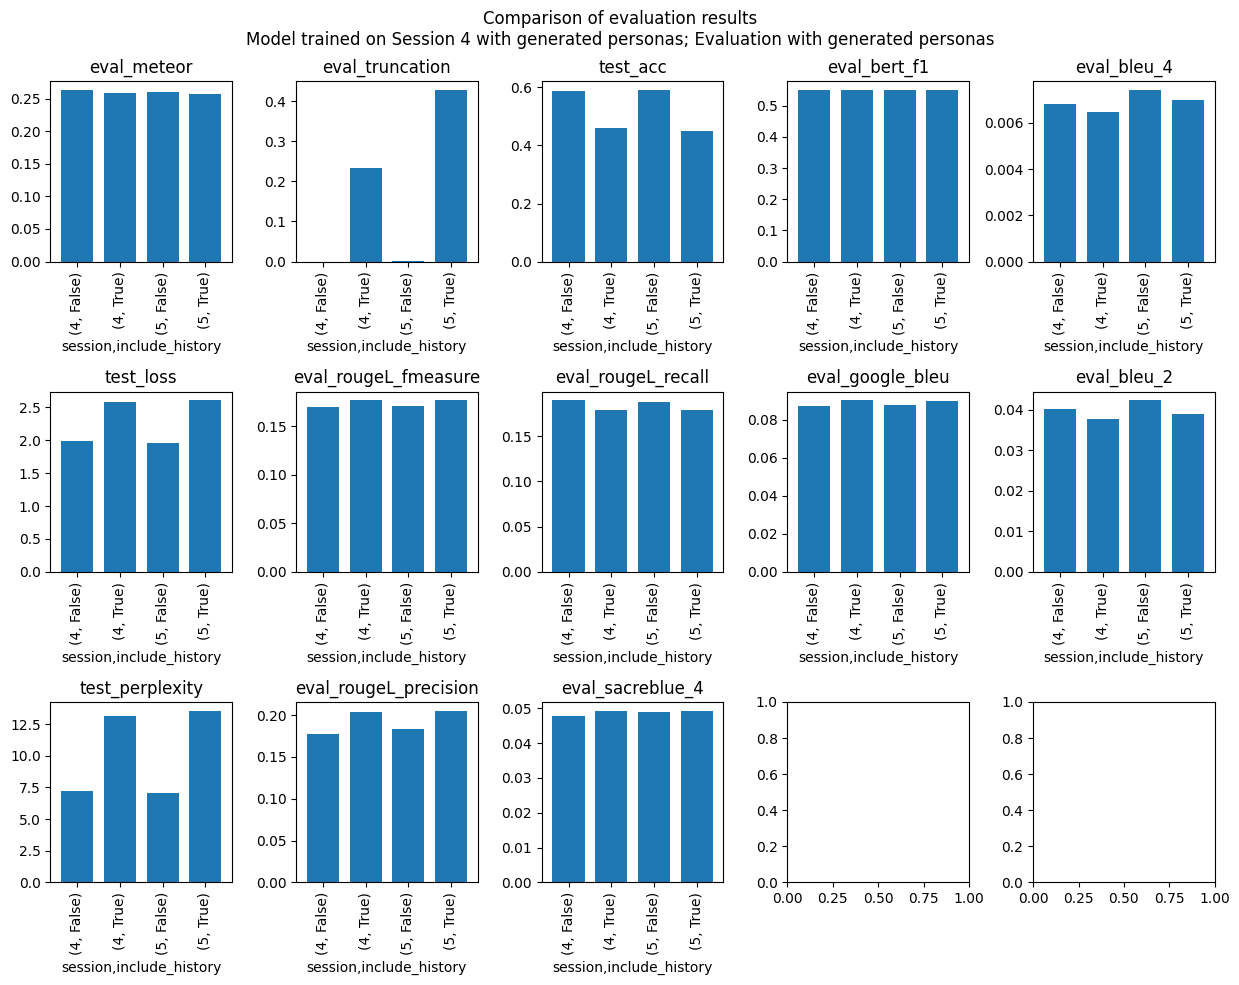

In [111]:
model_name = "trained_fb_hpc_s4_nll05bart_dgpt"

selection = (all_stats_df['input_order'] == 'history-personas-current') \
    & (all_stats_df['action'] == 'eval') \
    & (all_stats_df['date'] > '20230720') \
    & (all_stats_df['persona_selector'].notnull()) 
    # & (all_stats_df['load'] == model_name)
print("Number of trials in selection: ", len(all_stats_df[selection]))
print(all_stats_df[selection]['load'])

metrics = [c for c in all_stats_df[selection].columns if (c[:5] == 'eval_') or (c[:5] == 'test_' and c != 'test_samples')]
print("Num metrics: ", len(metrics))
grouplist = ['session', 'include_history']

df = all_stats_df[selection][grouplist + metrics].groupby(grouplist).mean()
metrics = list(set(metrics).intersection(df.columns))

fig, axs = plt.subplots(ncols=min(5, len(metrics)), nrows=1 + len(metrics) // 5, figsize=(2.5 * min(5, len(metrics)), 3 + 3 * len(metrics) // 5))

for metric, ax in zip(metrics, axs.flatten()):
    ax.set_title(metric)
    if len(df[metric]) > 0:
        df[metric].plot.bar(ax=ax, width=0.75)
    # for i, v in zip(range(len(df[metric].index)), df[metric].values):
    #     ax.text(i, v*1.1, f"{v:.2f}", horizontalalignment='center', verticalalignment='center', fontsize='small', c='k', rotation=90)
    # ax.set_ylim(df[metric].min()*0.9)

fig.suptitle("Comparison of evaluation results\nModel trained on Session 4 with generated personas; Evaluation with generated personas")
fig.tight_layout()

In [112]:
# collect results from the relevant trials in a dataframe 'results_df'

# selection = (all_stats_df['date'] > '20230619')
selection = (all_stats_df['input_order'] == 'history-personas-current') \
    & (all_stats_df['action'] == 'eval') \
    & (all_stats_df['date'] > '20230720')
decoder_options = ['do_sample', 'num_beams', 'temperature', 'top_p', 'top_k']
result_df = all_stats_df[selection][['session', 'load'] + decoder_options + metrics]
result_df['session'] = result_df['session'].astype(int)
result_df['load'] = result_df['load'].apply(lambda x: format_modelname(x))
gen_config_cat = CategoricalDtype(['Greedy', 'Unbiased sampling','Narrow beam', 'Flat-Narrow beam', 'Flat-Broad beam'], ordered=True)
result_df['gen_config'] = result_df[gen_config_params].apply(format_gen_config, axis=1).astype(gen_config_cat)
result_df = result_df.dropna(subset=['gen_config'])
result_df['num_beams'] = result_df['num_beams'].astype(int)
result_df['top_k'] = result_df['top_k'].astype(int)
result_df = result_df.sort_values(by=['do_sample', 'num_beams', 'top_k', 'temperature'])
result_df


,session,load,do_sample,num_beams,temperature,top_p,top_k,eval_meteor,eval_truncation,test_acc,...,eval_bleu_4,test_loss,eval_rougeL_fmeasure,eval_rougeL_recall,eval_google_bleu,eval_bleu_2,test_perplexity,eval_rougeL_precision,eval_sacreblue_4,gen_config
trial_name,,,,,,,,,,,,,,,,,,,,,
trained_hib_hpc_s4_dgpt_20230726_112518,4,Base,False,1,1.0,1.0,50,0.255866,0.234414,0.458561,...,0.008164,2.572959,0.184861,0.191336,0.090775,0.040756,13.105332,0.201636,0.056668,Greedy
trained_fb_hpc_s4_nll05bart_dgpt_20230726_115048,4,PERSUM,False,1,1.0,1.0,50,0.247855,0.000059,0.587462,...,0.006722,1.980894,0.167484,0.192578,0.082273,0.037117,7.249605,0.168125,0.051267,Greedy
trained_fb_hpc_s4_nll05bart_dgpt_20230726_124444,5,PERSUM,False,1,1.0,1.0,50,0.247471,0.001190,0.592185,...,0.008241,1.950453,0.171587,0.192921,0.083990,0.041285,7.032246,0.175242,0.053439,Greedy
trained_hib_hpc_s4_dgpt_20230724_220711,5,Base,False,1,1.0,1.0,50,0.252921,0.428994,0.449944,...,0.008512,2.608082,0.184208,0.191365,0.089615,0.041875,13.573818,0.201078,0.055880,Greedy
trained_fb_hpc_s4_nll05bart_dgpt_20230727_115032,5,PERSUM,True,1,1.0,1.0,0,0.247871,0.001190,0.592185,...,0.003218,1.950453,0.147393,0.165062,0.078954,0.030529,7.032246,0.156061,0.039811,Unbiased sampling
trained_hib_hpc_s4_dgpt_20230727_115241,5,Base,True,1,1.0,1.0,0,0.238605,0.428994,0.449944,...,0.002785,2.608082,0.148757,0.154096,0.079365,0.027492,13.573818,0.171327,0.039243,Unbiased sampling
trained_fb_hpc_s4_nll05bart_dgpt_20230727_114907,4,PERSUM,True,1,1.0,1.0,0,0.250729,0.000059,0.587462,...,0.002822,1.980894,0.147206,0.168568,0.078655,0.029155,7.249605,0.153795,0.038494,Unbiased sampling
trained_hib_hpc_s4_dgpt_20230727_115202,4,Base,True,1,1.0,1.0,0,0.239282,0.234414,0.458561,...,0.002772,2.572959,0.147723,0.154239,0.079750,0.026009,13.105332,0.168501,0.040012,Unbiased sampling
trained_fb_hpc_s4_nll05bart_dgpt_20230725_034459,5,PERSUM,True,5,1.0,0.9,10,0.253480,0.001190,0.592185,...,0.009676,1.950453,0.192091,0.177830,0.094008,0.040628,7.032246,0.242375,0.052466,Narrow beam


ValueError: Axis limits cannot be NaN or Inf

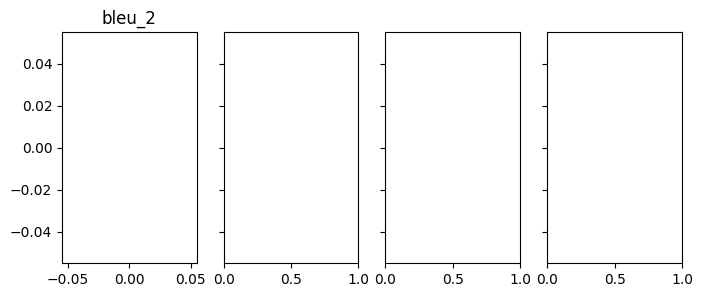

In [113]:
# Make subselection for one session
session = 4
subselection = (result_df['session'] == session) & (result_df['load'] == 'PEX')

# Define metrics to show
# eval_metrics = [m for m in metrics if m[:4] == 'eval' and m != 'eval_truncation']
eval_metrics = [
    # "eval_truncation", 
    # "eval_sacreblue_4", 
    "eval_bleu_2",
    "eval_bleu_4",
    # "eval_bert_f1",
    "eval_rougeL_fmeasure",
    # "eval_rougeL_precision",
    # "eval_rougeL_recall",
    "eval_meteor",
    # "eval_google_bleu"
]

# Define figure format
fig, axs = plt.subplots(ncols=len(eval_metrics), figsize=(2 * len(eval_metrics), 3), sharey=True)

# Loopt over metrics to plot bar charts
for m, ax in zip(eval_metrics, axs):

    # Plot bar chart
    ax_bar = ax.barh(y=list(range(len(result_df[subselection]))), width=result_df[subselection][m][::-1])

    # Print value in tha max bar, and color the bars
    max_value = result_df[subselection][m].max()
    x_min = result_df[subselection][m].min() * 0.6
    xticks = ax.get_xticks()
    digits = math.ceil(-math.log10((xticks[-1] - xticks[0])/len(xticks)))+1
    for i, v in enumerate(result_df[subselection][m][::-1]):
        if v == max_value:
            ax_bar[i].set_color('g')
            ax.text(x_min + (v - x_min) * 0.95, i, f"{v:.{digits}f}", ha='right', va='center', c='w', fontweight='bold')
        elif v > 0.95 * max_value:
            ax_bar[i].set_color('y')
    
    # Add title, other formatting
    ax.set_title(m[5:])
    ax.set_xlim(x_min)

# Remove labels n left side (to make room for the table)
axs[0].set_yticks([])
axs[0].set_yticklabels([])

# Plot a table with the parameters of the generation config
# NOTE: Table items are in reversed order compared to bars !!
ax_table = axs[0].table(cellText=result_df[subselection][decoder_options].values,
    colLabels=[o if len(o) < 8 else (o[:4] if (o.find('_') < 0) else o.split('_')[1]) for o in decoder_options],
    cellLoc='center',
    bbox=[-2, 0, 1.9, 1.15],
)
ax_table.auto_set_font_size(False)
ax_table.set_fontsize(10)

# Main title for the figure
fig.suptitle(f"Impact of various generation parameters on evaluation metrics for session {session}")
fig.tight_layout()

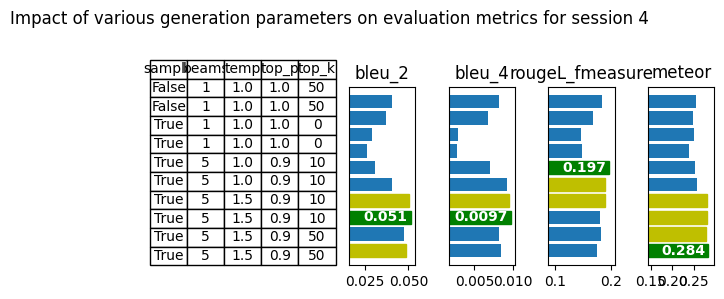

In [114]:
# Make subselection for one session
session = 4
subselection = result_df['session'] == session

# Define metrics to show
# eval_metrics = [m for m in metrics if m[:4] == 'eval' and m != 'eval_truncation']
eval_metrics = [
    # "eval_truncation", 
    # "eval_sacreblue_4", 
    "eval_bleu_2",
    "eval_bleu_4",
    # "eval_bert_f1",
    "eval_rougeL_fmeasure",
    # "eval_rougeL_precision",
    # "eval_rougeL_recall",
    "eval_meteor",
    # "eval_google_bleu"
]

# Define figure format
fig, axs = plt.subplots(ncols=len(eval_metrics), figsize=(2 * len(eval_metrics), 3), sharey=True)

# Loopt over metrics to plot bar charts
for m, ax in zip(eval_metrics, axs):

    # Plot bar chart
    ax_bar = ax.barh(y=list(range(len(result_df[subselection]))), width=result_df[subselection][m][::-1])

    # Print value in tha max bar, and color the bars
    max_value = result_df[subselection][m].max()
    x_min = result_df[subselection][m].min() * 0.6
    xticks = ax.get_xticks()
    digits = math.ceil(-math.log10((xticks[-1] - xticks[0])/len(xticks)))+1
    for i, v in enumerate(result_df[subselection][m][::-1]):
        if v == max_value:
            ax_bar[i].set_color('g')
            ax.text(x_min + (v - x_min) * 0.95, i, f"{v:.{digits}f}", ha='right', va='center', c='w', fontweight='bold')
        elif v > 0.95 * max_value:
            ax_bar[i].set_color('y')
    
    # Add title, other formatting
    ax.set_title(m[5:])
    ax.set_xlim(x_min)

# Remove labels n left side (to make room for the table)
axs[0].set_yticks([])
axs[0].set_yticklabels([])

# Plot a table with the parameters of the generation config
# NOTE: Table items are in reversed order compared to bars !!
ax_table = axs[0].table(cellText=result_df[subselection][decoder_options].values,
    colLabels=[o if len(o) < 8 else (o[:4] if (o.find('_') < 0) else o.split('_')[1]) for o in decoder_options],
    cellLoc='center',
    bbox=[-3, 0, 2.8, 1.15],
)
ax_table.auto_set_font_size(False)
ax_table.set_fontsize(10)

# Main title for the figure
fig.suptitle(f"Impact of various generation parameters on evaluation metrics for session {session}")
fig.tight_layout()

## Inspect results of individual dialogue samples

In [115]:
# Convert eval_results to DataFrame and combine with config

eval_df = pd.concat([
    pd.DataFrame.from_records(
        list(evalresults_dict[trial_name].values()),
        index=pd.MultiIndex.from_tuples(list(evalresults_dict[trial_name].keys()))  # do not include session in key (alreay in columns)
    )
    for trial_name in evalresults_dict.keys()
])
eval_df = eval_df.join(all_config_df, on='trial_name')
eval_df = eval_df.droplevel(0)
eval_df.reset_index(inplace=True, names=['dialog_id', 'turn_id'])
eval_df.head()

,dialog_id,turn_id,input_truncation,pred_response,target_response,bert_f1,bert_precision,bert_recall,speechacts,speechpattern,...,add_tokens,include_persona,include_history,input_order,sessionbreak_token,session,augmented,selected_turns,persona_selector,speechact_classifier
0,0,0,0.0,<self>I just signed up for a gym membership!,<self>How did it go with the gym signup?\n,0.570842,0.569813,0.571874,{'S': 1},S,...,None,True,False,history-personas-current,<session>,5,True,None,preprocessed:trained_nll05_bart,trained_speechact_bert
1,0,1,0.0,<self>It went great! I was able to sign up for...,<self>It went pretty well. It actually went be...,0.746915,0.772698,0.722797,"{'R': 1, 'S': 1}",RS,...,None,True,False,history-personas-current,<session>,5,True,None,preprocessed:trained_nll05_bart,trained_speechact_bert
2,0,2,0.0,<self>That's great. I'm glad you signed up for...,"<self>Congratulations! As you mentioned, you ...",0.609318,0.633466,0.586943,"{'R': 1, 'E': 2}",REE,...,None,True,False,history-personas-current,<session>,5,True,None,preprocessed:trained_nll05_bart,trained_speechact_bert
3,0,3,0.0,"<self>Yes, it is nice to work out at the gym a...",<self>I agree. I saw everyone working out alo...,0.610529,0.632745,0.589820,{'O': 1},O,...,None,True,False,history-personas-current,<session>,5,True,None,preprocessed:trained_nll05_bart,trained_speechact_bert
4,0,4,0.0,<self>I do a lot of cardio. I do a lot of car...,<self>I go to the gym at least five times a we...,0.581239,0.582995,0.579493,{'S': 3},SSS,...,None,True,False,history-personas-current,<session>,5,True,None,preprocessed:trained_nll05_bart,trained_speechact_bert


In [116]:
eval_df['gen_config'] = eval_df[gen_config_params].apply(format_gen_config, axis=1).astype(gen_config_cat)
eval_df['model_name'] = eval_df['load'].apply(format_modelname)

In [154]:
# Add BLEU and ROUGE scores per sample

bleu2_score_fn = BLEUScore(n_gram=2, smooth=True)
bleu4_score_fn = BLEUScore(n_gram=4, smooth=True)
rouge_score_fn = ROUGEScore(rouge_keys='rougeL')

eval_df['bleu2'] = eval_df[['pred_response', 'target_response']].apply(lambda x: bleu2_score_fn([x[0]],[[x[1]]]), axis=1)
eval_df['bleu4'] = eval_df[['pred_response', 'target_response']].apply(lambda x: bleu4_score_fn([x[0]],[[x[1]]]), axis=1)
eval_df['rougeL'] = eval_df[['pred_response', 'target_response']].apply(lambda x: rouge_score_fn(x[0],x[1])['rougeL_fmeasure'], axis=1)
eval_df[['pred_response', 'target_response', 'bleu2', 'bleu4', 'rougeL']].head(20)

In [164]:
eval_df.groupby(['session', 'model_name', 'gen_config'])[['bleu2', 'bleu4', 'rougeL']].agg(['mean', 'std'])

bleu2               bleu4            \
                                          mean       std      mean       std   
session model_name gen_config                                                  
4       Base       Greedy             0.025921  0.052789  0.001790  0.017263   
                   Unbiased sampling  0.012270  0.035063  0.000247  0.005498   
                   Narrow beam        0.022910  0.053104  0.001904  0.018031   
                   Flat-Narrow beam   0.032880  0.059193  0.001980  0.017549   
                   Flat-Broad beam    0.029265  0.055248  0.001514  0.015351   
        PERSUM     Greedy             0.023335  0.048678  0.001313  0.014500   
                   Unbiased sampling  0.014510  0.036330  0.000214  0.005657   
                   Narrow beam        0.027626  0.056257  0.002174  0.018030   
                   Flat-Narrow beam   0.034526  0.056720  0.002151  0.016447   
                   Flat-Broad beam    0.032097  0.053923  0.001565  0.014390   
5       Base       Greedy             0.026933  0.053109  0.001978  0.017756   
                   Unbiased sampling  0.013683  0.036273  0.000172  0.004617   
                   Narrow beam        0.024217  0.054173  0.002297  0.021130   
                   Flat-Narrow beam   0.035753  0.060573  0.002591  0.020572   
                   Flat-Broad beam    0.031486  0.055898  0.002082  0.018511   
        PERSUM     Greedy             0.025382  0.049502  0.001781  0.015217   
                   Unbiased sampling  0.014938  0.036922  0.000303  0.007181   
                   Narrow beam        0.028416  0.056155  0.002758  0.022170   
                   Flat-Narrow beam   0.036704  0.058307  0.002432  0.017801   
                   Flat-Broad beam    0.033950  0.055956  0.001583  0.014433   

                                        rougeL            
                                          mean       std  
session model_name gen_config                             
4       Base       Greedy             0.184861  0.070772  
                   Unbiased sampling  0.147724  0.053846  
                   Narrow beam        0.197167  0.076520  
                   Flat-Narrow beam   0.190195  0.067830  
                   Flat-Broad beam    0.182888  0.063407  
        PERSUM     Greedy             0.167485  0.066755  
                   Unbiased sampling  0.147207  0.050580  
                   Narrow beam        0.190042  0.073204  
                   Flat-Narrow beam   0.181118  0.062916  
                   Flat-Broad beam    0.176126  0.058772  
5       Base       Greedy             0.184208  0.069869  
                   Unbiased sampling  0.148757  0.052969  
                   Narrow beam        0.196952  0.079382  
                   Flat-Narrow beam   0.191696  0.069158  
                   Flat-Broad beam    0.183528  0.063739  
        PERSUM     Greedy             0.171587  0.065797  
                   Unbiased sampling  0.147394  0.049748  
                   Narrow beam        0.192091  0.073630  
                   Flat-Narrow beam   0.183079  0.064117  
                   Flat-Broad beam    0.177511  0.061235

In [161]:
for g in eval_df['gen_config'].unique():
    selection = (eval_df['session'] == 4) & (eval_df['model_name'] == "PERSUM") & (eval_df['gen_config'] == g)
    p, t = tuple(eval_df[selection][['pred_response', 'target_response']].values.T)
    print('{:<20} {:.4f}'.format(g, bleu2_score_fn(p, t.reshape(-1,1)).item()))

Narrow beam          0.0407
Greedy               0.0371
nan                  0.0000
Flat-Broad beam      0.0487
Flat-Narrow beam     0.0513
Unbiased sampling    0.0292


In [19]:
eval_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142620 entries, 0 to 142619
Data columns (total 60 columns):
 #   Column                Non-Null Count   Dtype   
---  ------                --------------   -----   
 0   dialog_id             142620 non-null  int64   
 1   turn_id               142620 non-null  int64   
 2   input_truncation      142620 non-null  float64 
 3   pred_response         142620 non-null  object  
 4   target_response       142620 non-null  object  
 5   bert_f1               142620 non-null  float64 
 6   bert_precision        142620 non-null  float64 
 7   bert_recall           142620 non-null  float64 
 8   speechacts            142620 non-null  object  
 9   speechpattern         142620 non-null  object  
 10  trial_name            142620 non-null  object  
 11  configfile            0 non-null       object  
 12  seed                  142620 non-null  int64   
 13  checkpoint_dir        142620 non-null  object  
 14  output_dir            142620 non-nul

In [20]:
msc_session = MSC_Session(
    basedir="/Users/FrankVerhoef/Programming/PEX/data/msc/msc_dialogue/", 
    session=4, 
    subset='test', 
    include_history=False,
    include_persona=True,
    persona_selector='preprocessed:trained_nll05_bart', # None means 'gold' persona
    persona_selector_fn=lambda turns: [],  # no persona sentences added to the preprocessed personas
    augmented=True
)
dialog_id = 1
turn_id = 4
i = msc_session.find(dialog_id=dialog_id, turn_id=turn_id)

print("History:")
print(msc_session[i][0].replace('\n', ' \\\\ \n').replace('<','\\textless ').replace('>','\\textgreater '))
print("Target:")
print(msc_session[i][1].replace('<self>', ''))


2024-02-15 01:39:03,029 INFO     | Read 501 dialogues from MSC session 4 for test dataset
2024-02-15 01:39:03,030 INFO     | Loading preprocessed summaries from: /Users/FrankVerhoef/Programming/PEX/data/msc/msc_dialogue/preprocessed:trained_nll05_bart:session_4_test.json


History:
I am girl. \\ 
I am a young girl who is still in highschool. \\ 
I enjoy marching band in the fall and concert band in the season. \\ 
My parents are both teachers. \\ 
My favorite subject is english. \\ 
I play a band in school. \\ 
I play football for my high school. \\ 
I play the trumpet. \\ 
I live in Oklahoma City. \\ 
I have never been to a school concert. I am busy. \\ 
I work on music and academics. \\ 
I am nervous to go to a concert. \\ 
I am always nervous in crowds. \\ 
I need to look for someone to go with me. \\ 
I am shy. I wear magic sword t shirts. \\ 
I am going to a concert. \\ 
I have a fave band. \\ 
My favorite band is Roxy. I have 2 older brothers. \\ 
I am from meself. \\ 
I just moved to Charlotte, NC. \\ 
I went to a concert. \\ 
I have a brother. I have seen the first time a band plays. \\ 
I want to pursue my dreams of music. \\ 
I have a new farm in Charlotte. \\ 
I grow corn, potatoes, squash, and tomatoes. \\ 
I know you grow many crops on your 

In [22]:
msc_session = MSC_Session(
    basedir="/Users/FrankVerhoef/Programming/PEX/data/msc/msc_dialogue/", 
    session=4, 
    subset='test', 
    include_history=True,
    include_persona=True,
    persona_selector="init_persona", 
    persona_selector_fn=lambda turns: [],  # no persona sentences except init_persona
    augmented=True
)
dialog_id = 1
turn_id = 4
i = msc_session.find(dialog_id=dialog_id, turn_id=turn_id)

print("History:")
print(msc_session[i][0].replace('\n', ' \\\\ \n').replace('<','\\textless ').replace('>','\\textgreater '))
print("Target:")
print(msc_session[i][1].replace('<self>', ''))


2024-02-15 01:39:25,929 INFO     | Read 501 dialogues from MSC session 4 for test dataset
2024-02-15 01:39:25,955 INFO     | Saving extracted persona sentences to: /Users/FrankVerhoef/Programming/PEX/data/msc/msc_dialogue/preprocessed:init_persona:session_4_test.json
History:
I am girl. \\ 
I am a young girl who is still in highschool. \\ 
I enjoy marching band in the fall and concert band in the season. \\ 
My parents are both teachers. \\ 
My favorite subject is english. \\ 
Hello there! \\ 
Hi! How are you doing? \\ 
Well, thank you. How are you? \\ 
Fab, thanks! I'm here to see my fave band play. I drove 1,000 miles for it! \\ 
Wow, so cool. What's your favorite band? \\ 
Roxy music. My 2 older brothers took me to see them when I was a kid. \\ 
That's so cool! I actually play band in school. \\ 
Did you? What do you do now? I'm from farmer stock, meself. \\ 
I play for my high school, so it's nothing too cool. Haha! \\ 
No, it's totally cool. What instrument? \\ 
I play the trumpet

In [23]:
# Print the predicted utterances, for various generation configs

# Select an id to print
session = 4
dialog_id = 1
turn_id = 4
selection = (eval_df['session'] == session) & (eval_df['dialog_id'] == dialog_id) & (eval_df['turn_id'] == turn_id)

# Define relevant selection from eval_results
selected_metrics = ['speechacts', 'speechpattern']
results_df = eval_df[selection][['pred_response', 'target_response', 'model_name', 'gen_config'] + selected_metrics].sort_values(by=['gen_config'])

pex_responses = results_df[results_df['model_name'] == 'PEX'][['gen_config', 'pred_response', 'speechpattern']].set_index('gen_config')
base_responses = results_df[results_df['model_name'] == 'Base'][['gen_config', 'pred_response', 'speechpattern']].set_index('gen_config')
table_df = base_responses.join(pex_responses, on=['gen_config'], how='inner', lsuffix='_base', rsuffix='_pex')
table_df


,pred_response_base,speechpattern_base,pred_response_pex,speechpattern_pex
gen_config,,,,


In [16]:
s = table_df.style.format({
    'pred_response_base': '{{ {} }}', 
    'pred_response_pex': '{{ {} }}', 
})
print(s.to_latex(hrules=True, clines="all;data").replace('<self>', ''))
s

\begin{tabular}{lllll}
\toprule
 & pred_response_base & speechpattern_base & pred_response_pex & speechpattern_pex \\
gen_config &  &  &  &  \\
\midrule
\bottomrule
\end{tabular}



,pred_response_base,speechpattern_base,pred_response_pex,speechpattern_pex
gen_config,,,,


### Print predictions for one dialogue, for different generation configs

In [24]:
# Get the config for one of the trials in the selection
session = 4
subselection = result_df['session'] == session
trial_names = result_df[subselection].index.values
print(trial_names)
msc_session_config = [c for c in config_list if c['trial_name'] == trial_names[0]][0]
msc_session_config

NameError: name 'result_df' is not defined

In [31]:
MSC_Session.set(speaker_prefixes=msc_session_config['speaker_prefixes'], sessionbreak_token='<session>') #msc_session_config['sessionbreak_token'])
msc_session = MSC_Session(
    basedir="/Users/FrankVerhoef/Programming/PEX/data/msc/msc_dialogue/",
    session=session, 
    subset='test', 
    include_history=msc_session_config['include_history'],
    include_persona=msc_session_config['include_persona'],
    persona_selector=msc_session_config['persona_selector'],
    persona_selector_fn=None if msc_session_config['persona_selector'] != 'init_persona' else lambda turns: [],
    augmented=msc_session_config['augmented']
)

2023-09-05 22:41:45,676 INFO     | Read 501 dialogues from MSC session 4 for test dataset
2023-09-05 22:41:45,677 INFO     | Loading preprocessed summaries from: /Users/FrankVerhoef/Programming/PEX/data/msc/msc_dialogue/preprocessed:trained_nll05_bart:session_4_test.json


In [32]:
dialog_id = 1
turn_id = 4
i = msc_session.find(dialog_id=dialog_id, turn_id=turn_id)
df = result_df[subselection][decoder_options + ['load']]
df['pred_response'] = [evalresults_dict[t][session, dialog_id, turn_id]['pred_response'] for t in df.index]

print("History:")
print(msc_session[i][0])
print("Target:")
print(msc_session[i][1])

print(tabulate(df.sort_values(by=['load', 'do_sample', 'num_beams', 'top_k', 'temperature']), headers='keys', tablefmt='outline', showindex=False))


History:
<session>personas
<self>I am girl.
<self>I am a young girl who is still in highschool.
<self>I enjoy marching band in the fall and concert band in the season.
<self>My parents are both teachers.
<self>My favorite subject is english.
<self>I play a band in school.
<self>I play football for my high school.
<self>I play the trumpet.
<self>I live in Oklahoma City.
<self>I have never been to a school concert. I am busy.
<self>I work on music and academics.
<self>I am nervous to go to a concert.
<self>I am always nervous in crowds.
<self>I need to look for someone to go with me.
<self>I am shy. I wear magic sword t shirts.
<self>I am going to a concert.
<other>I have a fave band.
<other>My favorite band is Roxy. I have 2 older brothers.
<other>I am from meself.
<other>I just moved to Charlotte, NC.
<other>I went to a concert.
<other>I have a brother. I have seen the first time a band plays.
<other>I want to pursue my dreams of music.
<other>I have a new farm in Charlotte.
<other>I g